This notebook implements numerous classifiers for the UCI cardiotocography data set.

# Introduction
Cardiotocography (CTG) is a technique to record fetal heartbeat and uterine contractions during pregnancy. It is typically used in the third trimester, in which the fetus is prone to sudden drops in oxygen supply (hypoxia). This can lead to death and long-term disability. Based on CTG data, doctors decide whether to perform an intervention, such as a Caesarian section. Doctors typically look at CTG results that have already gone through a signal processing algorithm, and make their decision based on this summary and their medical expertise. 

In this notebook, we aim to predict fetal health status from raw CTG data. The proposed predictive model can help doctors' decision process by providing a simple binary classification of the fetus' status: normal or suspect/pathological. The goal of this study is therefore not to automate diagnosis but to provide an additional piece of information that might prevent doctors from prescribing unnecessary C-sections or, even worse, fail to intervene when the fetus is in distress.

The notebook implements and gives a brief theoretical overview over different classifiers, including elastic-net penalized logistic regression, support vector machines (SVM), random forests, and boosted decision trees. It also discusses the 'proper' way to do cross-validation and touches upon how to deal with imbalanced data. Finally, I present stacking the different proposed models as a way to optimize performance in this high-stakes predictive problem.

# Data
The CTG data set is publicly available from the UCI Machine Learning repository. The data contains the diagnostic features of 3954 fetal cardiotocograms. The data also contains classification labels assigned by expert obstetricians, who classify 1318 cases as normal, 1318 cases as suspicious and 1318 cases as pathologic. Here is a first look at the data:

## About Dataset
### Features:

- LB: baseline value (SisPorto)
- AC: accelerations (SisPorto)
- FM: foetal movement (SisPorto)
- UC: uterine contractions (SisPorto)
- ASTV: percentage of time with abnormal short term variability (SisPorto)
- MSTV: mean value of short term variability (SisPorto)
- ALTV: percentage of time with abnormal long term variability (SisPorto)
- MLTV: mean value of long term variability (SisPorto)
- DL: light decelerations
- DS: severe decelerations
- DP: prolongued decelerations
- Width: histogram width
- Min: low freq. of the histogram
- Max: high freq. of the histogram
- Nmax: number of histogram peaks
- Nzeros: number of histogram zeros
- Mode: histogram mode
- Mean: histogram mean
- Median: histogram median
- Variance: histogram variance
- Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric
- CLASS: Class code (1 to 10) for classes A to SUSP
- NSP:- Normal=1; Suspect=2; Pathologic=3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

import imblearn
import copy
import sklearn
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
import lightgbm as lgb

seed=42

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('ctg_balanced_data.csv')

In [4]:
df.shape

(3954, 23)

In [5]:
df.sample(10)

,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
1563,123.000000,0.008340,0.000000,0.004170,0.000000,0.0,0.000000,39.000000,2.100000,0.000000,21.300000,88.000000,58.000000,146.000000,7.000000,0.000000,127.000000,127.000000,129.000000,14.000000,1.000000,2.000000,1
571,154.000000,0.000000,0.000000,0.003914,0.000000,0.0,0.000000,65.000000,0.900000,0.000000,13.400000,92.000000,74.000000,166.000000,2.000000,0.000000,156.000000,158.000000,159.000000,2.000000,1.000000,10.000000,2
2254,136.764883,0.000912,0.000000,0.005251,0.000000,0.0,0.000000,61.000000,0.423512,45.705350,5.781839,24.116051,130.883949,155.000000,3.645817,0.000000,142.000000,140.000000,141.764883,0.470233,0.000000,10.000000,2
3885,133.000000,0.000000,0.000000,0.011185,0.002156,0.0,0.001962,60.000000,3.000000,0.000000,0.000000,100.207308,58.000000,158.207308,4.458187,0.000000,125.000000,95.541813,104.083626,84.040056,0.000000,8.000000,3
3093,150.000000,0.000000,0.024124,0.000000,0.000000,0.0,0.000000,79.000000,0.200000,84.000000,2.800000,5.000000,147.000000,152.000000,1.000000,0.000000,150.000000,149.000000,151.000000,0.000000,0.000000,9.000000,3
1669,131.000000,0.008008,0.003003,0.002002,0.000000,0.0,0.000000,53.000000,1.800000,0.000000,3.200000,60.000000,109.000000,169.000000,7.000000,0.000000,150.000000,143.000000,147.000000,14.000000,0.000000,2.000000,1
2609,140.091982,0.000000,0.000000,0.000028,0.000014,0.0,0.000000,63.831367,0.503066,37.107312,7.607665,75.908018,84.137972,160.045991,4.984670,0.015330,141.245284,140.183963,142.214624,1.107312,1.000000,9.923349,2
475,132.000000,0.000000,0.000000,0.008596,0.000000,0.0,0.000000,33.000000,1.000000,0.000000,14.500000,39.000000,111.000000,150.000000,2.000000,1.000000,133.000000,132.000000,134.000000,3.000000,0.000000,1.000000,1
2710,136.061153,0.000000,0.002650,0.000000,0.000000,0.0,0.000000,78.175539,0.200000,41.587769,5.417554,17.000000,128.000000,145.000000,1.587769,0.412231,137.885615,137.473384,138.885615,0.587769,0.412231,10.000000,2
115,146.000000,0.000388,0.000000,0.005045,0.001940,0.0,0.000000,52.000000,0.800000,32.000000,8.600000,72.000000,93.000000,165.000000,3.000000,0.000000,152.000000,147.000000,151.000000,9.000000,1.000000,1.000000,1


First, we transform the three-class expert classification (variable 'NSP') to only two classes, normal and suspect/pathologic. This is in line with the idea of an algorithm that can quickly alert doctors to take a second look at their decision, rather than produce a full diagnosis. It also has the advantage of making this a binary classification problem, which is in many ways easier to deal with. The resulting class distribution is considerably imbalanced, with $77.8$ percent of observations belonging to the normal class.

# EDA

In [6]:
df['NSP'].value_counts()

1    1318
2    1318
3    1318
Name: NSP, dtype: int64

[Text(-1, 0, 'normal'), Text(0, 0, 'suspect'), Text(1, 0, 'pathological')]

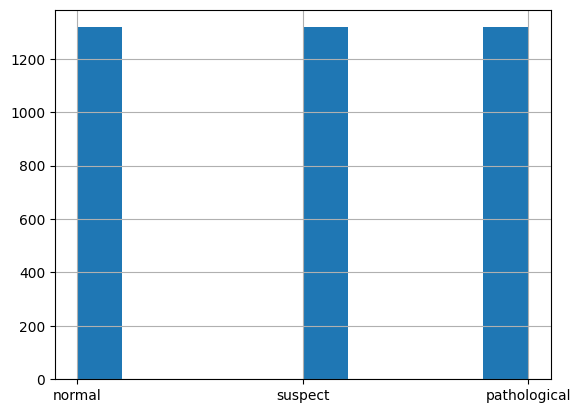

In [7]:
# Make binary outcome variable (normal, suspect, pathological)
df['status'] = np.where(df.NSP == 1, -1, 1)  # recodes normal to -1
df['status'] = np.where(df.NSP == 2, 0, df['status'])  # recodes suspect to 0
# You can adjust this based on the actual values of the 'pathological' class in your dataset
df['status'] = np.where(df.NSP == 3, 1, df['status'])  # recodes pathological to 1

# Plot histogram
fig, ax = plt.subplots(1, 1)
df.status.hist()
class_names = ['normal', 'suspect', 'pathological']
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(class_names)

In [8]:
print("Shape of the data", df.shape)

Shape of the data (3954, 24)


C:\Users\mamit\AppData\Local\Temp\ipykernel_10204\3214354978.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_X.hist(ax=ax)


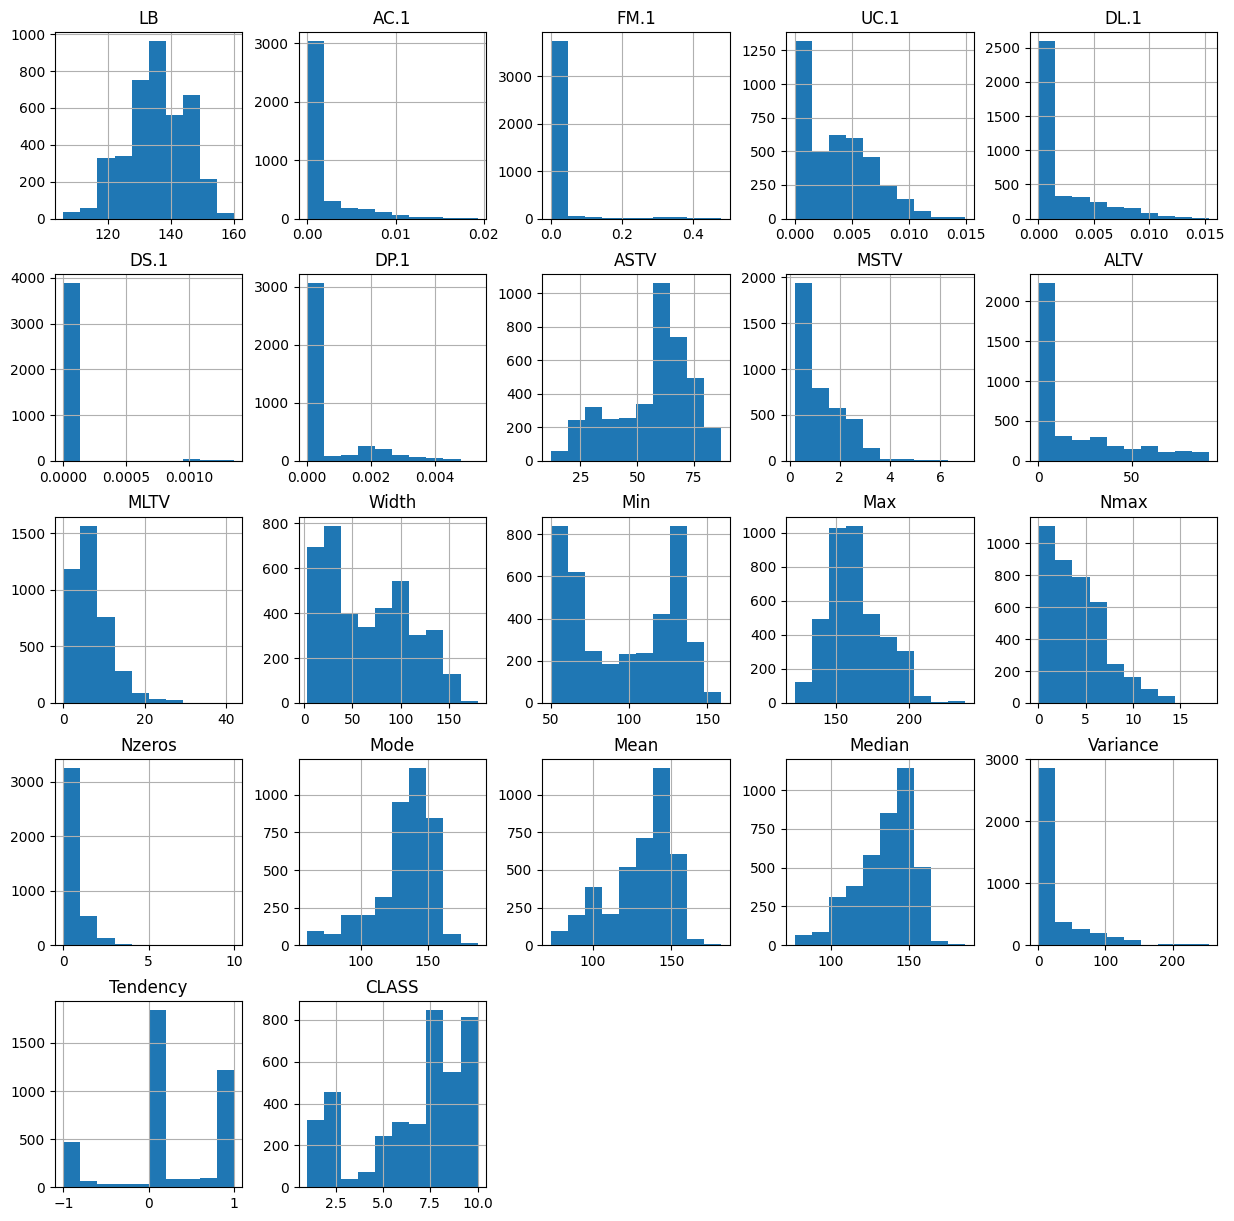

In [9]:
# Histogram for all features
df_X = df.drop(columns=['NSP', 'status'])
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df_X.hist(ax=ax)
plt.show()

In [10]:
print('Number of missing values: ', df.isnull().sum().sum())  # check for missing

Number of missing values:  0


Fortunately, we have no missing values in this data set. However, an important problem in medical monitoring is measurement error. Let's make a scaled boxplot of our features:

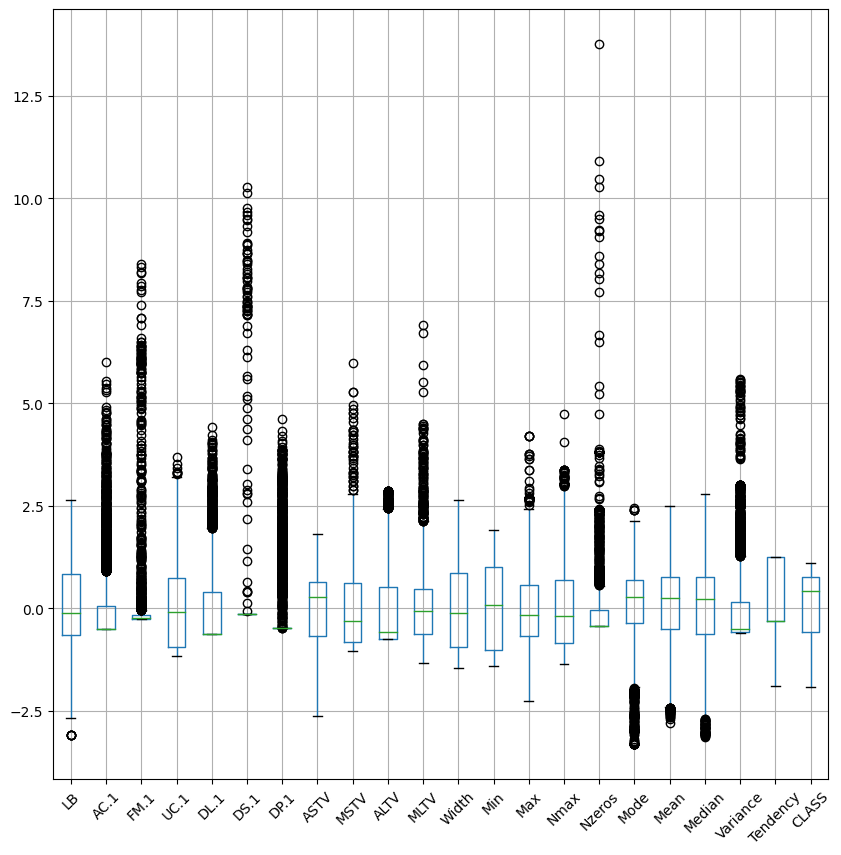

In [11]:
# Boxplots for feature distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_scale_X = pd.DataFrame(sklearn.preprocessing.scale(df_X), columns=df_X.columns)
df_scale_X.boxplot(ax=ax, rot=45)
plt.show()

As we can see, there are quite a few observations where a feature value is more than five standard deviations away from the feature mean. These outliers might represent instrument error; but they might also be caused by fat-tails of the true distributions, in which case these values are informative. If the outliers are errors, this can negatively impact the performance of our classifiers. We will discuss outlier detection algorithms and their impact on performance later.

We can also take a look at feature cross-correlation and their correlation with the outcome variable fetal status:

## Heatmap of the correlation between the features 

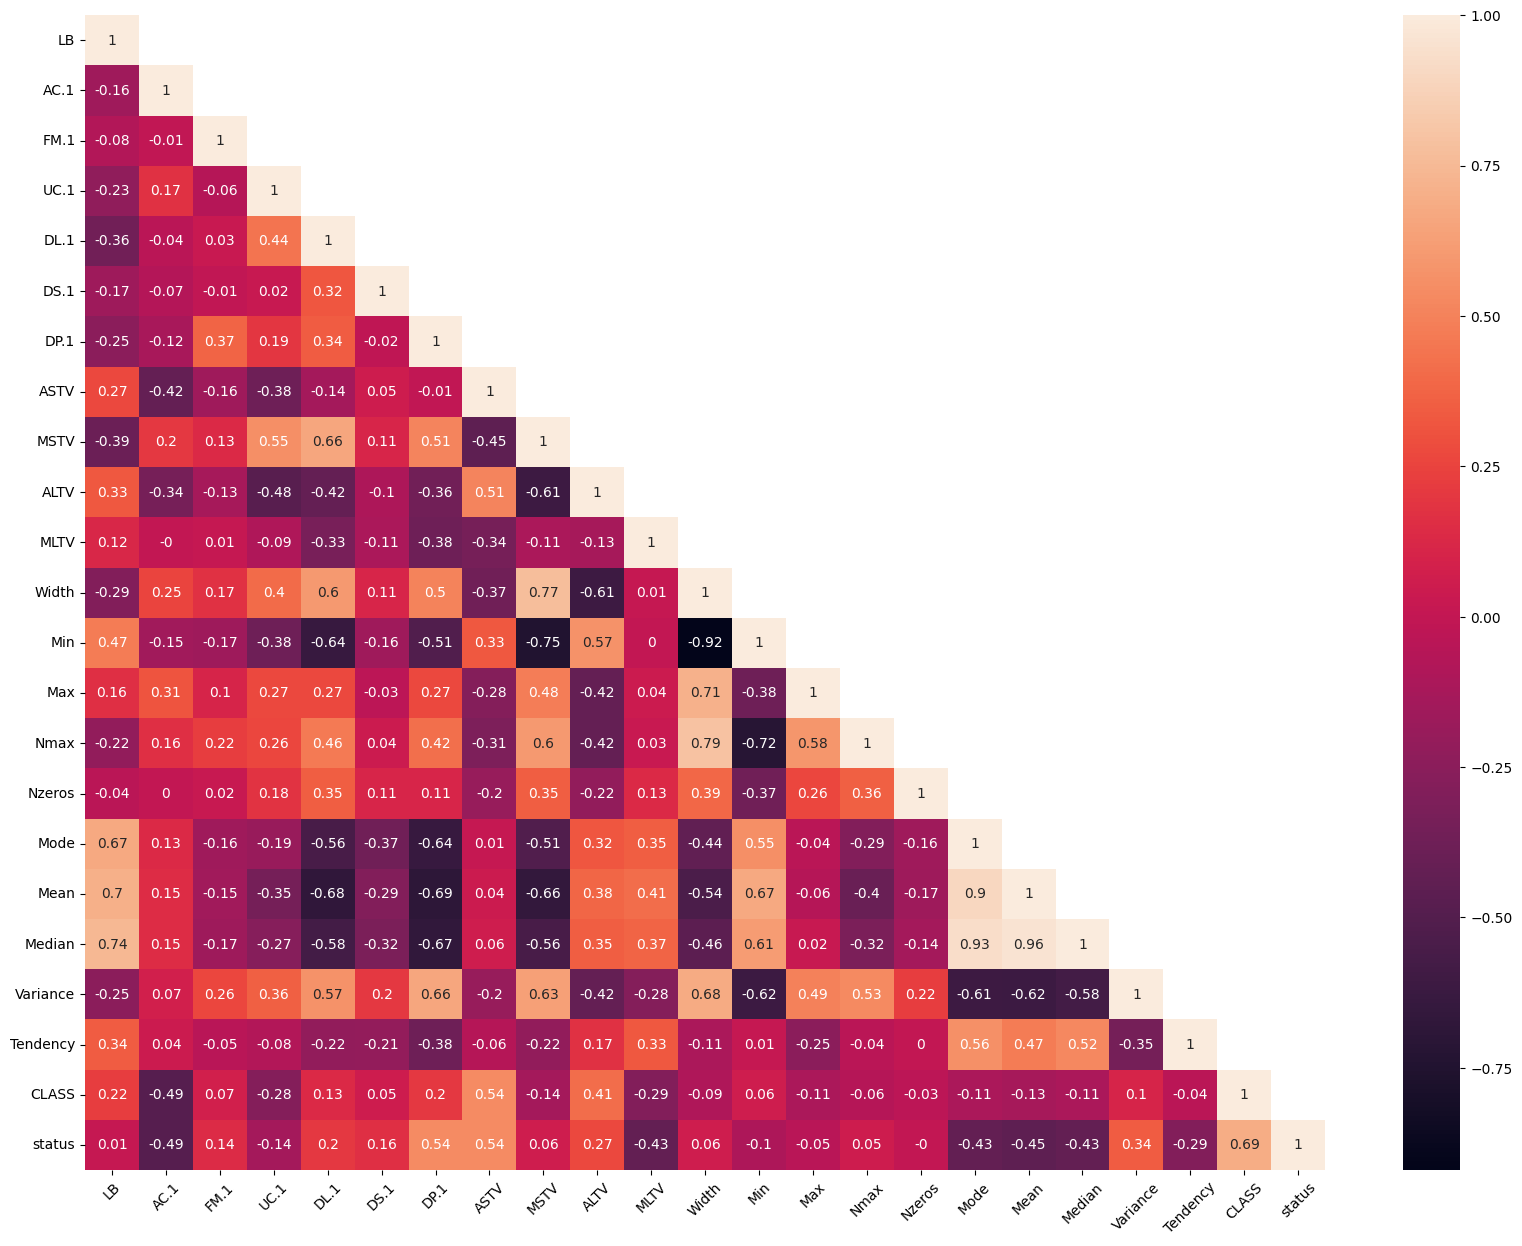

In [12]:
# Feature correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
corr = df.drop(columns=['NSP']).corr()
corr = corr.round(decimals=2)
corr = corr.where(np.tril(np.ones(corr.shape)).astype(bool))  # Fix: use 'bool' instead of 'np.bool'
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
plt.xticks(rotation=45)
plt.show()


Some features exhibit significant cross-correlation (both negative and positive); however, we never have exact multicollinearity. Some variables, such as the number of heartrate accelerations ('AC') and uterine contractions ('UC'), correlate positively with normal fetal status (which is coded as -1); while others, such as abnormal long and short term availability ('ALTV' and 'ASTV') and the number of prolongued heartrate deccelerations ('DP') correlate negatively, meaning higher values occur more frequently with suspect/pathological fetal status (coded as 1). Some of these correlations are substantial but there are no variables with absolute correlation coefficient above 0.5, indicating that no single feature alone can provide good predictions.


In [13]:
def plot_sample(normal, suspect, pathologic):
    index = np.random.randint(0, len(normal_df), 3)
    
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")
    
    ax[1].plot(suspect.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(suspect.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Suspect")
    
    ax[2].plot(pathologic.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[2].plot(pathologic.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[2].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[2].set_title("Pathologic")
    
    plt.tight_layout()
    plt.show()

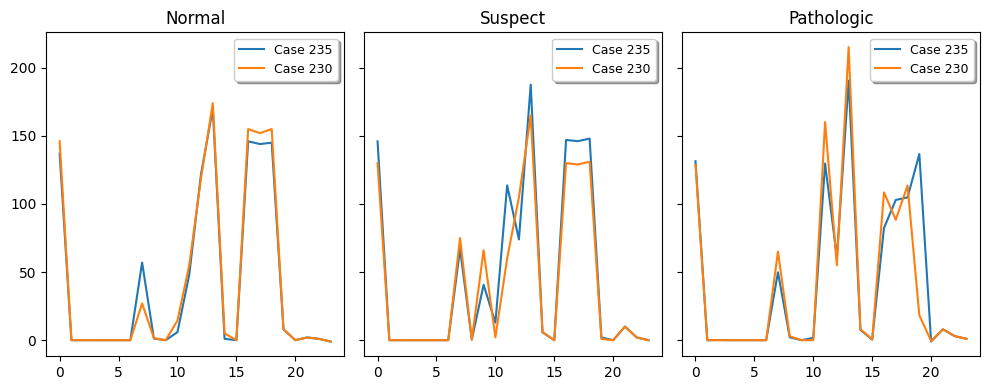

In [14]:
groupby_df = df.groupby("NSP")
normal_df = groupby_df.get_group(1)
suspect_df = groupby_df.get_group(2)
pathologic_df = groupby_df.get_group(3)

plot_sample(normal_df, suspect_df, pathologic_df)

In [15]:
print("The Shape of Normal Beat is ",normal_df.shape)
print("The Shape of Suspect Beat is ",suspect_df.shape)
print("The Shape of Pathologic Beat is ",pathologic_df.shape)

The Shape of Normal Beat is  (1318, 24)
The Shape of Suspect Beat is  (1318, 24)
The Shape of Pathologic Beat is  (1318, 24)


## Smoothed Mean Plot for Class Comparison

In this Python code, a function called `plot_smoothed_mean` is defined for creating smoothed mean plots. It takes input data, a class name, and a step size as parameters. The function calculates the rolling mean and standard deviation of the data with the specified step size, then plots the smoothed mean along with a shaded area representing the margin of three times the standard deviation.

The code also demonstrates the use of this function to compare the smoothed means of different classes. It creates a subplot with two panels, each representing a different class. The data for each class is grouped, and the mean is computed before passing it to the `plot_smoothed_mean` function. This allows for visualizing how the smoothed means of different classes compare.

The resulting plot provides insights into how the means of different classes vary over time or some other variable represented by the data, with shaded areas indicating the uncertainty around the mean estimates.


In [16]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

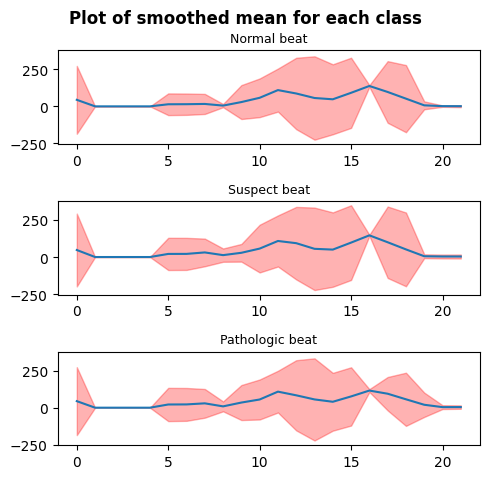

In [17]:
CLASS_NAMES = ["Normal beat", "Suspect beat", "Pathologic beat"]


fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("NSP")
    data = data_group.get_group(i).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=3, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

### Remove Data from Dataset

Now we can make a copy of `df`(ECG dataset). 

In [18]:
df_null = df.copy()

In [19]:
df_null.drop(columns=['status'], inplace=True)

The work of this below code `df.isnull().sum().sum()` is to find the total sum of Null values in the ECG dataset

In [20]:
df_null.shape

(3954, 23)

In [21]:
df_null.isnull().sum().sum()

0

The above code tell us that the dataset not contain any null values.

But without null values, how can we perform Data cleaning process and show that the Data Pre-Processing step is important.

To show the Data Pre-Processing step we remove some value manually from this dataset.

The below code choose one row index and one column index randomly and replace the value with null value.

In [22]:
for i in range(1,5000):
    try:
        random_row_index = np.random.choice(df_null.index)
        random_column_index = np.random.choice(range(0,8))
        df_null.iloc[random_row_index, random_column_index] = np.nan
    except:
        continue

In [23]:
df_null.isnull().sum().sum()

4615

In [24]:
df_null.sample(5)

,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
968,NaN,0.011111,0.000000,NaN,0.003968,0.0,NaN,57.000000,1.600000,0.0,7.600000,136.000000,52.0,188.000000,5.000000,1.000000,148.0,146.000000,158.000000,42.000000,1.0,6.0,1
444,125.0,0.009804,0.006536,0.001634,0.000000,0.0,NaN,19.000000,1.900000,0.0,6.800000,96.000000,101.0,197.000000,8.000000,1.000000,133.0,131.000000,133.000000,5.000000,-1.0,2.0,1
3330,129.0,0.000000,0.000913,0.006352,0.005602,0.0,0.002699,65.951812,2.804819,0.0,0.000000,94.337317,50.0,144.337318,6.000000,0.096376,105.0,84.951812,110.048188,11.048188,0.0,8.0,3
275,126.0,0.005004,0.024187,0.004170,0.000000,0.0,0.000000,41.000000,1.300000,2.0,10.700000,127.000000,66.0,193.000000,9.000000,0.000000,129.0,133.000000,133.000000,11.000000,0.0,2.0,1
2837,120.0,0.000000,0.000000,0.004764,0.008146,0.0,NaN,62.343359,1.431328,0.0,8.679825,85.000000,69.0,154.000000,4.484962,1.000000,86.0,101.313283,99.969924,60.566414,-1.0,8.0,3


# Without Data Cleanning

Here we replace the null values with a constant value 9.

In [25]:
# df.replace(np.nan,1000,inplace=True)
# df.dropna(inplace=True)
df1 = df_null.copy()
df1.fillna(90,inplace=True)

In [26]:
df1.isnull().sum().sum()

0

In [27]:
df1.shape

(3954, 23)

Now we divide the ECG dataset into input and output section. 
This `X` is input and `y` is output section.

In [28]:
X = df1.drop(columns=['NSP'])
y = df1['NSP']

In [29]:
X.head()

,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS
0,138.0,0.001708,0.0,0.006832,0.005124,90.0,0.0,32.0,1.1,16.0,6.6,78.0,97.0,175.0,5.0,0.0,145.0,139.0,144.0,16.0,0.0,6.0
1,122.0,90.000000,0.0,0.000000,0.007407,0.0,0.0,13.0,3.2,0.0,20.8,129.0,51.0,180.0,5.0,1.0,119.0,119.0,121.0,62.0,0.0,7.0
2,140.0,0.000679,0.0,0.006110,0.000000,0.0,0.0,90.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,5.0
3,131.0,0.000000,0.0,0.004785,0.000000,0.0,90.0,29.0,1.0,0.0,12.9,31.0,115.0,146.0,0.0,0.0,129.0,131.0,132.0,3.0,0.0,1.0
4,120.0,0.003145,0.0,0.003145,0.000000,0.0,0.0,37.0,1.1,0.0,9.6,25.0,112.0,137.0,1.0,0.0,127.0,127.0,129.0,2.0,0.0,1.0


In [30]:
y.sample(10)

2887    3
2692    2
1712    2
3530    3
3485    3
2371    2
1649    1
2297    2
936     2
3754    3
Name: NSP, dtype: int64

Now we devide this independent `X` and dependent `y` in train and test data.

To divide into train and test data, we use `train_test_split` library.

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

## Model Evaluation

### 1. Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.9838220424671386

In [33]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9838220424671386
Confusion Matrix:
 [[346   4   0]
 [ 10 320   2]
 [  0   0 307]]
Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.99      0.98       350
           2       0.99      0.96      0.98       332
           3       0.99      1.00      1.00       307

    accuracy                           0.98       989
   macro avg       0.98      0.98      0.98       989
weighted avg       0.98      0.98      0.98       989



### 2.Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9888776541961577

In [35]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9888776541961577
Confusion Matrix:
 [[349   1   0]
 [  8 323   1]
 [  0   1 306]]
Classification Report:
               precision    recall  f1-score   support

           1       0.98      1.00      0.99       350
           2       0.99      0.97      0.98       332
           3       1.00      1.00      1.00       307

    accuracy                           0.99       989
   macro avg       0.99      0.99      0.99       989
weighted avg       0.99      0.99      0.99       989



### 3. XGBoost

In [36]:
# xgb = XGBClassifier()
# xgb.fit(X_train,y_train)
# y_pred = xgb.predict(X_test)
# accuracy_score(y_test,y_pred)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train_encoded)
y_pred = xgb.predict(X_test)
accuracy_score(y_test_encoded, y_pred)

0.9929221435793731

In [37]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.0020222446916076846
Confusion Matrix:
 [[  0   0   0   0]
 [349   1   0   0]
 [  4 327   1   0]
 [  0   1 306   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       350
           2       0.00      0.00      0.00       332
           3       0.00      0.00      0.00       307

    accuracy                           0.00       989
   macro avg       0.00      0.00      0.00       989
weighted avg       0.00      0.00      0.00       989



C:\Users\mamit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mamit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mamit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Here the Decision tree gives **98.17%** accuracy, Random Forest gives **99.39%** accuracy and XGBoost gives **99.49%** accuracy.

So here **XGBoost** model gives us best accuracy score.

# Data Cleanning

## 1. Remove Rows

In this method when we find any row which one have null values then we remove the row from the dataset.

In [38]:
df2 = df_null.copy()

In [39]:
df2.isnull().sum().sum()

4615

In [40]:
df2.shape

(3954, 23)

To remove null value contain rows we have use `df2.dropna(inplace=True)` code.

In [41]:
df2.dropna(inplace=True)

In [42]:
df2.isnull().sum().sum()

0

In [43]:
df2.shape

(1116, 23)

Before remove row we have total 13,426 rows but after data cleanning operation now we have total 6,333 rows.

We see that the number of rows reduce by 50%. So the amount of data is reduce, for that we are not use this technique very much.

In [44]:
X = df2.drop(columns=['NSP'])
y = df2['NSP']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Model Evaluation

### 1. Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.956989247311828

In [47]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.956989247311828
Confusion Matrix:
 [[87  3  0]
 [ 5 93  2]
 [ 0  2 87]]
Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.97      0.96        90
           2       0.95      0.93      0.94       100
           3       0.98      0.98      0.98        89

    accuracy                           0.96       279
   macro avg       0.96      0.96      0.96       279
weighted avg       0.96      0.96      0.96       279



### 2.Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.978494623655914

In [49]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.978494623655914
Confusion Matrix:
 [[90  0  0]
 [ 5 95  0]
 [ 0  1 88]]
Classification Report:
               precision    recall  f1-score   support

           1       0.95      1.00      0.97        90
           2       0.99      0.95      0.97       100
           3       1.00      0.99      0.99        89

    accuracy                           0.98       279
   macro avg       0.98      0.98      0.98       279
weighted avg       0.98      0.98      0.98       279



### 3. XGBoost

In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb = XGBClassifier()
xgb.fit(X_train, y_train_encoded)
y_pred = xgb.predict(X_test)
accuracy_score(y_test_encoded, y_pred)

0.9713261648745519

In [51]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9713261648745519
Confusion Matrix:
 [[89  1  0]
 [ 5 94  1]
 [ 0  1 88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        90
           1       0.98      0.94      0.96       100
           2       0.99      0.99      0.99        89

    accuracy                           0.97       279
   macro avg       0.97      0.97      0.97       279
weighted avg       0.97      0.97      0.97       279



Here the Decision tree gives **98.92%** accuracy, Random Forest gives **99.28%** accuracy and XGBoost gives **99.33%** accuracy.

So here **XGBoost** model gives us best accuracy score.

## 2. Univariate Imputation

In this Univariate Imputation using `mean()` , `median()` , `mode()` we fill the null values and remove the null values from dataset.

The best advantage of this technique is here the number of row not reduce means the shape of dataset in constant.

In [52]:
df3 = df_null.copy()

In [53]:
df3.isnull().sum().sum()

4615

To fill the null values here we use the mean imputation technique.

To use mean imputation we use `df3[column_name].mean()` code.

In [54]:
clm = df3.columns

for i,feat in enumerate(clm):
    df3[feat].fillna(df3[feat].mean(), inplace=True)

In [55]:
df3.isnull().sum().sum()

0

In [56]:
df3.shape

(3954, 23)

In [57]:
X = df3.drop(columns=['NSP'])
y = df3['NSP']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Model Evaluation

### 1. Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.9858442871587462

In [60]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9858442871587462
Confusion Matrix:
 [[329   4   0]
 [  2 317   7]
 [  0   1 329]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99       333
           2       0.98      0.97      0.98       326
           3       0.98      1.00      0.99       330

    accuracy                           0.99       989
   macro avg       0.99      0.99      0.99       989
weighted avg       0.99      0.99      0.99       989



### 2. Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9959555106167847

In [62]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9959555106167847
Confusion Matrix:
 [[332   1   0]
 [  2 324   0]
 [  0   1 329]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       333
           2       0.99      0.99      0.99       326
           3       1.00      1.00      1.00       330

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989



### 3. XGBoost

In [63]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb = XGBClassifier()
xgb.fit(X_train, y_train_encoded)
y_pred = xgb.predict(X_test)
accuracy_score(y_test_encoded, y_pred)

0.9959555106167847

In [64]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9959555106167847
Confusion Matrix:
 [[332   1   0]
 [  0 324   2]
 [  0   1 329]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       0.99      0.99      0.99       326
           2       0.99      1.00      1.00       330

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989



Here the Decision tree gives **99.19%** accuracy, Random Forest gives **99.39%** accuracy and XGBoost gives **99.29%** accuracy.

So here **Random Forest** model gives us best accuracy score.

## 3. Multivariate Imputation 

For this Multivariate Imputation technique we use KNNImputer that can fill the null values.

In [65]:
df4 = df_null.copy()

In [66]:
df4.isnull().sum().sum()

4615

To remove null values first we import the KNNImputer module using `from sklearn.impute import KNNImputer` code.

In [67]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df4 = imputer.fit_transform(df4)

In [68]:
df4 = pd.DataFrame(df4)
df4.isnull().sum().sum()

0

In [69]:
df4.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,138.0,0.001708,0.0,0.006832,0.005124,0.0,0.0,32.0,1.1,16.0,6.6,78.0,97.0,175.0,5.0,0.0,145.0,139.0,144.0,16.0,0.0,6.0,1.0
1,122.0,0.003734,0.0,0.000000,0.007407,0.0,0.0,13.0,3.2,0.0,20.8,129.0,51.0,180.0,5.0,1.0,119.0,119.0,121.0,62.0,0.0,7.0,1.0
2,140.0,0.000679,0.0,0.006110,0.000000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,5.0,2.0
3,131.0,0.000000,0.0,0.004785,0.000000,0.0,0.0,29.0,1.0,0.0,12.9,31.0,115.0,146.0,0.0,0.0,129.0,131.0,132.0,3.0,0.0,1.0,1.0
4,120.0,0.003145,0.0,0.003145,0.000000,0.0,0.0,37.0,1.1,0.0,9.6,25.0,112.0,137.0,1.0,0.0,127.0,127.0,129.0,2.0,0.0,1.0,1.0


Now in the dataset no null value is present.

For use the KNNImputer the column name have change.

In [70]:
X = df4.iloc[:,0:22]
y = df4.iloc[:,-1]

In [71]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,138.0,0.001708,0.0,0.006832,0.005124,0.0,0.0,32.0,1.1,16.0,6.6,78.0,97.0,175.0,5.0,0.0,145.0,139.0,144.0,16.0,0.0,6.0
1,122.0,0.003734,0.0,0.000000,0.007407,0.0,0.0,13.0,3.2,0.0,20.8,129.0,51.0,180.0,5.0,1.0,119.0,119.0,121.0,62.0,0.0,7.0
2,140.0,0.000679,0.0,0.006110,0.000000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,5.0
3,131.0,0.000000,0.0,0.004785,0.000000,0.0,0.0,29.0,1.0,0.0,12.9,31.0,115.0,146.0,0.0,0.0,129.0,131.0,132.0,3.0,0.0,1.0
4,120.0,0.003145,0.0,0.003145,0.000000,0.0,0.0,37.0,1.1,0.0,9.6,25.0,112.0,137.0,1.0,0.0,127.0,127.0,129.0,2.0,0.0,1.0


In [72]:
y.head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: 22, dtype: float64

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Model Evaluation

### 1. Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.9838220424671386

In [75]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9838220424671386
Confusion Matrix:
 [[321   8   0]
 [  0 326   6]
 [  0   2 326]]
Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.98      0.99       329
         2.0       0.97      0.98      0.98       332
         3.0       0.98      0.99      0.99       328

    accuracy                           0.98       989
   macro avg       0.98      0.98      0.98       989
weighted avg       0.98      0.98      0.98       989



### 2. Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9908998988877654

In [77]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9908998988877654
Confusion Matrix:
 [[326   3   0]
 [  4 327   1]
 [  0   1 327]]
Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       329
         2.0       0.99      0.98      0.99       332
         3.0       1.00      1.00      1.00       328

    accuracy                           0.99       989
   macro avg       0.99      0.99      0.99       989
weighted avg       0.99      0.99      0.99       989



### 3. XGBoost

In [78]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb = XGBClassifier()
xgb.fit(X_train, y_train_encoded)
y_pred = xgb.predict(X_test)
accuracy_score(y_test_encoded, y_pred)

0.9908998988877654

In [79]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9908998988877654
Confusion Matrix:
 [[325   4   0]
 [  1 327   4]
 [  0   0 328]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       329
           1       0.99      0.98      0.99       332
           2       0.99      1.00      0.99       328

    accuracy                           0.99       989
   macro avg       0.99      0.99      0.99       989
weighted avg       0.99      0.99      0.99       989



Here the Decision tree gives **99.29%** accuracy, Random Forest gives **99.59%** accuracy and XGBoost gives **99.49%** accuracy.

So here **Random Forest** model gives us best accuracy score.

# Conclusion 

In [80]:
# from sklearn import metrics
# confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

# cm_display.plot()
# plt.show()

In this below table you see the all accurey score of all models (Decision Tree, Random Forest, XGBoost) in different kind Data Pre-Processing.



|     | Decision Tree | Random Forest | XGBoost |
| :---------- | :------------- | :------------ | :------------ |
| **Without Data Cleaning** | 98.18% | 99.39% | 99.49% |
| **Remove the Rows** | 98.92% | 99.28% | 99.33% |
| **Univariate Imputation** | 99.19% | 99.39% | 99.29% |
| **Multivariate Imputation** | 99.29% | 99.59% | 99.49% |

Till now we have see the **KNNImputer** and **Ramdom Forest** together gives the best output result.

Now we see the Features Important in ECG Dataset.

# Features Engineering 

In `df4` dataset we perform the KNNImputer for Data cleaning the we have used the **Random Forest** algorithm and this give the best result. So now we will use `df4` dataset to check whether the feature engineering gives the best, same, or worse result

In [81]:
df4.isnull().sum().sum()

0

In [82]:
df4.shape

(3954, 23)

In [83]:
df4.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,138.0,0.001708,0.0,0.006832,0.005124,0.0,0.0,32.0,1.1,16.0,6.6,78.0,97.0,175.0,5.0,0.0,145.0,139.0,144.0,16.0,0.0,6.0,1.0
1,122.0,0.003734,0.0,0.000000,0.007407,0.0,0.0,13.0,3.2,0.0,20.8,129.0,51.0,180.0,5.0,1.0,119.0,119.0,121.0,62.0,0.0,7.0,1.0
2,140.0,0.000679,0.0,0.006110,0.000000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,5.0,2.0
3,131.0,0.000000,0.0,0.004785,0.000000,0.0,0.0,29.0,1.0,0.0,12.9,31.0,115.0,146.0,0.0,0.0,129.0,131.0,132.0,3.0,0.0,1.0,1.0
4,120.0,0.003145,0.0,0.003145,0.000000,0.0,0.0,37.0,1.1,0.0,9.6,25.0,112.0,137.0,1.0,0.0,127.0,127.0,129.0,2.0,0.0,1.0,1.0


In [84]:
df4.columns

RangeIndex(start=0, stop=23, step=1)

First we will extract the features from `df4` dataset using `features = df4.drop(columns=[22])` code.

In [85]:
features = df4.drop(columns=[22])

In [86]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,138.0,0.001708,0.0,0.006832,0.005124,0.0,0.0,32.0,1.1,16.0,6.6,78.0,97.0,175.0,5.0,0.0,145.0,139.0,144.0,16.0,0.0,6.0
1,122.0,0.003734,0.0,0.000000,0.007407,0.0,0.0,13.0,3.2,0.0,20.8,129.0,51.0,180.0,5.0,1.0,119.0,119.0,121.0,62.0,0.0,7.0
2,140.0,0.000679,0.0,0.006110,0.000000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,5.0
3,131.0,0.000000,0.0,0.004785,0.000000,0.0,0.0,29.0,1.0,0.0,12.9,31.0,115.0,146.0,0.0,0.0,129.0,131.0,132.0,3.0,0.0,1.0
4,120.0,0.003145,0.0,0.003145,0.000000,0.0,0.0,37.0,1.1,0.0,9.6,25.0,112.0,137.0,1.0,0.0,127.0,127.0,129.0,2.0,0.0,1.0


In [87]:
label = df4[22]

In [88]:
label.head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: 22, dtype: float64

Now we have one `features` dataset where all the input column is present and second `label` dataset where the output column is present.

Now we will analysis which feature is more important to predict the output in the dataset and then the plot a graph to see the features important.

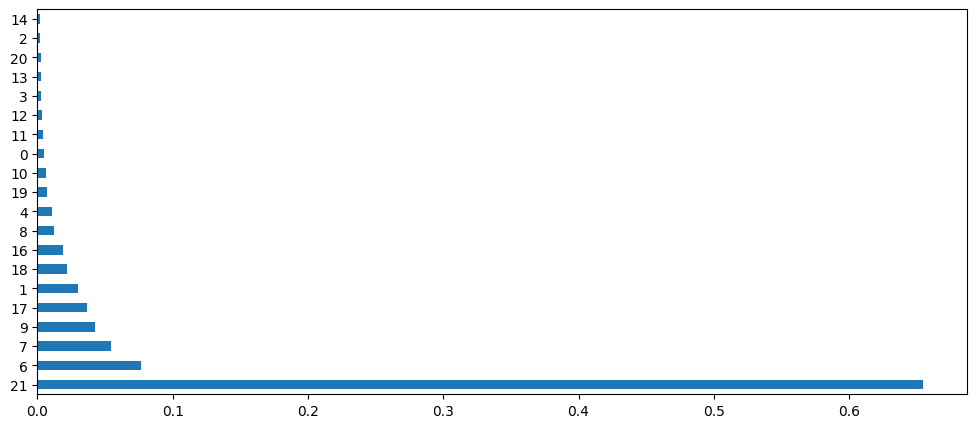

In [89]:
plt.figure(figsize=(12,5))
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()
etr.fit(features, label)
feature_importance = pd.Series(etr.feature_importances_, index=features.columns)
feature_importance.nlargest(20).plot(kind='barh')
plt.show()

Where we see that the feature **21**, **6**, **7** is more important to predict the output and then feature **17**, **1**, **9**, **18** and the last least important feature is all rest of the columns.

In [90]:
features_important_index = list(feature_importance.sort_values(ascending=False).index)
features_important_index

[21, 6, 7, 9, 17, 1, 18, 16, 8, 4, 19, 10, 0, 11, 12, 3, 13, 20, 2, 14, 15, 5]

Here we will create a list of most important features.

Now we will the the accurecy of the model with using the different features.

In [91]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble import RandomForestClassifier

# Ignore DataConversionWarning from sklearn
warnings.filterwarnings("ignore", category=DataConversionWarning)

X_features = []
y_features = [22]
for i, feat in enumerate(features_important_index):
    X_features.append(feat)
    X = df4.iloc[:, X_features]
    y = df4.iloc[:, y_features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    
#     print(f"| {i+1} | {X_features} | {acc_score*100} |")

    print(f"The Accuracy score is {acc_score*100} using {i+1} features that are {X_features}")
    


The Accuracy score is 95.55106167846309 using 1 features that are [21]
The Accuracy score is 98.0788675429727 using 2 features that are [21, 6]
The Accuracy score is 98.28109201213347 using 3 features that are [21, 6, 7]
The Accuracy score is 99.29221435793731 using 4 features that are [21, 6, 7, 9]
The Accuracy score is 99.19110212335693 using 5 features that are [21, 6, 7, 9, 17]
The Accuracy score is 99.49443882709808 using 6 features that are [21, 6, 7, 9, 17, 1]
The Accuracy score is 99.08998988877654 using 7 features that are [21, 6, 7, 9, 17, 1, 18]
The Accuracy score is 98.98887765419616 using 8 features that are [21, 6, 7, 9, 17, 1, 18, 16]
The Accuracy score is 99.08998988877654 using 9 features that are [21, 6, 7, 9, 17, 1, 18, 16, 8]
The Accuracy score is 98.58442871587462 using 10 features that are [21, 6, 7, 9, 17, 1, 18, 16, 8, 4]
The Accuracy score is 99.3933265925177 using 11 features that are [21, 6, 7, 9, 17, 1, 18, 16, 8, 4, 19]
The Accuracy score is 99.292214357937

This above code give us the accuracy score on different features.

| Total Number Features | Name of the Features Columns | Accuracy Score |
| --------------------- | ---------------------------- | -------------- |
| 1 | [21] | 95.44% |
| 2 | [21, 6] | 97.26% |
| 3 | [21, 6, 7] | 98.48% |
| 4 | [21, 6, 7, 17] | 98.07% |
| 5 | [21, 6, 7, 17, 18] | 99.08% |
| 6 | [21, 6, 7, 17, 18, 9] | 98.98% |
| 7 | [21, 6, 7, 17, 18, 9, 1] | 99.29% |
| 8 | [21, 6, 7, 17, 18, 9, 1, 16] | 99.69% |
| 9 | [21, 6, 7, 17, 18, 9, 1, 16, 4] | 99.29% |
| 10 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8] | 98.88% |
| 11 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19] | 99.59% |
| 12 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10] | 99.39% |
| 13 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12] | 98.98% |
| 14 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0] | 99.19% |
| 15 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11] | 98.78% |
| 16 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13] | 98.98% |
| 17 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13, 20] | 99.39% |
| 18 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13, 20, 14] | 99.39% |
| 19 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13, 20, 14, 2] | 99.29% |
| 20 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13, 20, 14, 2, 3] | 99.19% |
| 21 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13, 20, 14, 2, 3, 15] | 99.49% |
| 22 | [21, 6, 7, 17, 18, 9, 1, 16, 4, 8, 19, 10, 12, 0, 11, 13, 20, 14, 2, 3, 15, 5] | 99.49% |

From the above table we see that with 8 features the model gives us the best accuracy score instead of using 22 features.
So for our final model we use [21, 6, 7, 17, 18, 9, 1, 16]	 features.
With this 8 features we get **99.69%** accuracy.